In [1]:
from keras.models import load_model
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
rgb_dir='/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/rgb'
seg_dir='/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/seg'

images_path = list(sorted([ os.path.join(rgb_dir, fname) for fname in os.listdir(rgb_dir) ]))
segmentations_path = list(sorted([ os.path.join(seg_dir, fname) for fname in os.listdir(seg_dir)]))

In [3]:
test_images = []
test_seg = []
for i in range(5):
  images = cv2.imread(images_path[i])
  seg_img = cv2.imread(segmentations_path[i])
  seg_img = cv2.resize(images,(256,256,))
  images = cv2.resize(images,(256,256,))
  images = cv2.cvtColor(images,cv2.COLOR_BGR2RGB)
  test_images.append(images)
  test_seg.append(seg_img)

In [4]:
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,BatchNormalization,Activation,Dropout
from keras.models import Model

def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(img_height, img_width, nclasses=3, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('softmax')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

model = Unet(256,256,nclasses = 13, filters =64)
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/final_weight_for_semantic_segmentation/weights2.h5')

In [5]:
predicted_images = []
getshape = test_images[0].shape
for i in range(len(test_images)):
  newimg = np.zeros((256,256))
  #print(pred)
  pred = model.predict(test_images[i].reshape(1,getshape[0],getshape[1],getshape[2]))
  for i in range(13):
      for j in range(256):
          for k in range(256):
              if pred[0,j,k,i] > 0.4:
                  newimg[j,k] = i
  predicted_images.append(newimg)

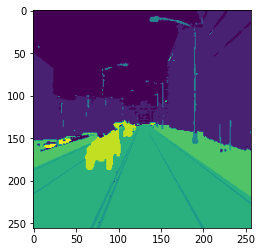

In [6]:
plt.imshow(predicted_images[0])

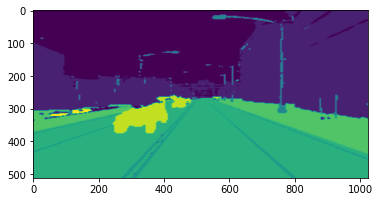

In [7]:
predicted_images[0].astype('float32')
predicted_mask_resize = cv2.resize(predicted_images[0],(1024,512,))
plt.imshow(predicted_mask_resize)

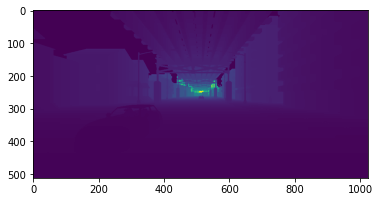

In [8]:
depth_path = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/depth_img_2.png'
depth_img = cv2.imread(depth_path,-1)
depth_img = depth_img/100.0
plt.imshow(depth_img)

In [9]:
cam_mtx = np.array([
    [358.5, 0.0,   512.0],
    [0.0,   358.5, 256.0],
    [0.0,   0.0,   1.0],  
])

def xy_from_depth(depth_img,cam_matrix):
    # Get the shape of the depth tensor
    H,W = depth_img.shape
    # Grab required parameters from the cam matrix
    f = cam_matrix[0,0]
    px = cam_matrix[0,2]
    py = cam_matrix[1,2]
    # Generate a grid of coordinates corresponding to the shape of the depth image
    nx, ny = (H, W)
    xa = np.arange(1, W+1, 1)
    ya = np.arange(1, H+1, 1)
    u, v = np.meshgrid(xa, ya)
    # Compute x and y coordinates
    x = (u - px)*depth_img/f
    y = (-v + py)*depth_img/f
    return x,y
    
x,y = xy_from_depth(depth_img,cam_matrix=cam_mtx)

In [10]:

# Get vehicles mask by choosing pixels in segmentation output with value 10
vehicles_mask_predicted = np.zeros(predicted_mask_resize.shape)
vehicles_mask_predicted[predicted_mask_resize == 10] = 1


# Get x,y, and z coordinates of pixels in vehicles mask
x_ground_predicted = x[vehicles_mask_predicted == 1]
y_ground_predicted = y[vehicles_mask_predicted == 1]
z_ground_predicted = depth_img[vehicles_mask_predicted == 1]
xyz_ground_predicted = np.stack((x_ground_predicted, y_ground_predicted, z_ground_predicted))



In [11]:
x_ground_predicted.shape

(10783,)

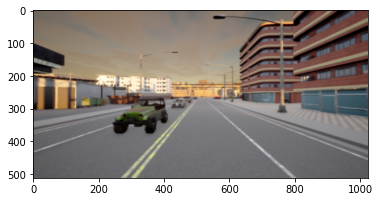

In [12]:
test_image_resize = cv2.resize(test_images[0],(1024,512))
plt.imshow(test_image_resize)

In [25]:
H, W = test_image_resize.shape[:2]
labels = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/3D_bbx_without_deepLearning/00_.txt")
def drawBBs(BBs, img):
    H, W = img.shape[:2]
    twoDbbx_info = []
    bbx_center = []
    for BB in BBs:
        u = BB[1]*W
        v = BB[2]*H
        w = BB[3]*W
        h = BB[4]*H

        # twoD_infor = [u,v,w,h]
        twoDbbx_info.append([u,v,w,h])
        
        c = int(BB[0])
        x_min = BB[5]
        x_max = BB[6]
        y_min = BB[5]
        y_max = BB[6]
        z_min = BB[5]
        z_max = BB[6]

        s = (int(u - w // 2), int(v - h // 2))
        e = (int(u + w // 2), int(v + h // 2))
        cv2.rectangle(img, s, e, (255,0,0), 1)
        bbx_center.append([s,e])
        tl = (s[0], s[1]+15)
        bl = (s[0], e[1]-5)
        # cv2.putText(img,str('Car'),tl,cv2.FONT_HERSHEY_COMPLEX_SMALL,0.75,colors[c])
        #coords = "(%.2f, %.2f, %.2f, %.2f, %.2f, %.2f)" % (x_min, x_max, y_min, y_max, z_min, z_max)
        #cv2.putText(img,coords,bl,cv2.FONT_HERSHEY_COMPLEX_SMALL,0.65,colors[c])
    
    return img,twoDbbx_info,bbx_center
img = test_image_resize
img,twoD_infor,bbx_center = drawBBs(labels, img)

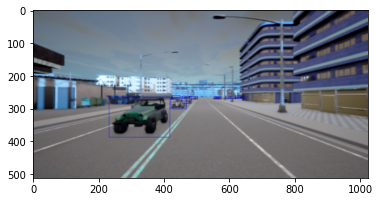

In [20]:
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# img_rgb = cv2.circle(img_rgb,(int(u),int(v)),7,(0,255,0),1)
plt.imshow(img_rgb)

In [28]:
bbx_center[0][0]

(423, 260)

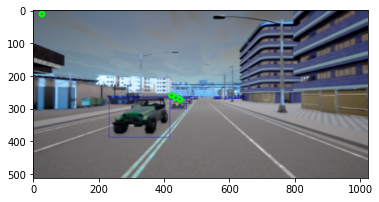

In [33]:
img_rgb = cv2.circle(img_rgb,bbx_center[0][0],7,(0,255,0),5)
plt.imshow(img_rgb)

In [36]:
import pandas as pd
extrinsic_cam = np.load("/content/drive/MyDrive/Colab Notebooks/3D_bbx_without_deepLearning/00_.npy").reshape((4,4))
extrinsic_cam

array([[ 9.99943278e-01,  2.38306197e-06, -1.06511482e-02,
         2.79967999e-01],
       [-2.38240175e-06,  1.00000004e+00,  2.53927492e-08,
        -5.95149476e-06],
       [ 1.06511479e-02,  7.27595675e-12,  9.99943256e-01,
         4.34936509e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [37]:
c_u = extrinsic_cam[0,2]
c_v = extrinsic_cam[1,2]
f_u = extrinsic_cam[0,0]
f_v = extrinsic_cam[1,1]
b_x = extrinsic_cam[0,3]/(-f_u)
b_y = extrinsic_cam[1,3]/(-f_v)

In [48]:
pts_3d_rect = np.stack((x,y,depth_img),axis=-1)
pts_3d_rect.shape

(512, 1024, 3)

In [ ]:
def draw_3dbbx(image, qs, color=(255,255,255), thickness=2):
    ''' Draw 3d bounding box in image
        qs: (8,3) array of vertices for the 3d box in following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
    '''
    qs = qs.astype(np.int32)
    for k in range(0,4):
       # Ref: http://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html
       i,j=k,(k+1)%4
       # use LINE_AA for opencv3
       cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness, cv2.CV_AA)
 
       i,j=k+4,(k+1)%4 + 4
       cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness, cv2.CV_AA)
 
       i,j=k,k+4
       cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness, cv2.CV_AA)
    return image